**Reinforcement Learning Final Project - Stock Trading Algorithm**
<br>
Implementation using the 
"anytrading" environment in OpenAIGym
<br>
https://github.com/AminHP/gym-anytrading

In [1]:
pip install gym-anytrading

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 KB 392.1 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing the OpenAIGym Environment for stock trading
import gym
import gym_anytrading

env = gym.make('stocks-v0')

In [45]:
from gym_anytrading.datasets import STOCKS_GOOGL

custom_env = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 1,
               frame_bound = (1, 500))

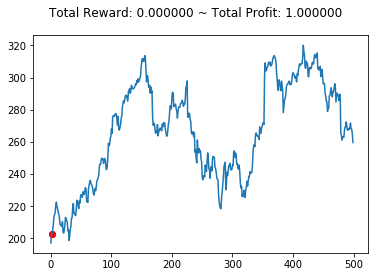

In [46]:
custom_env.reset()
custom_env.render()

In [41]:
# Google Stock dataset
custom_env.df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000


Max_possible_profit signifies that if the market didn't have trade fees, you could have earned 14.315119099453709 units of currency by starting with 1.0. In other words, your money increased over 1400%.

In [42]:
custom_env.max_possible_profit()

14.315119099453709

In [48]:
print(custom_env.action_space)
# 0 for sell and 1 for buying

Discrete(2)


In [49]:
action = 1
print(custom_env.step(action))

(array([[202.382385,   5.43544 ]]), 0, False, {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1})


In [ ]:
observation, reward, done, 